# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tt-dataset/zSample_Submission.csv
/kaggle/input/tt-dataset/Train.csv
/kaggle/input/tt-dataset/Test.csv


In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Importação de bibliotecas
import re
import emoji
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import itertools

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Bibliotecas do scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree, export_graphviz
from sklearn.metrics import accuracy_score

# Word cloud
from wordcloud import WordCloud

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Reading data

In [5]:
train = pd.read_csv('/kaggle/input/tt-dataset/Train.csv')
predict = pd.read_csv('/kaggle/input/tt-dataset/Test.csv')

In [6]:
train.head(10)

id                                         tweet_text  \
0  1049158578504916992                   @Vini_Arisato eu espero que não    
1  1049104603332169728  me diz aí o que vai ser do serviço social com ...   
2  1050780236856651776  inclusive, os nomes que eu uso aqui são de tes...   
3  1047555890654728192  @rangerlol1 Hora da panelinha começar a passar...   
4  1046965203701829632                           Meu neosoro tá acabando    
5  1046940789195067393  @unodded Eu queria mt aproveitar a minha pra r...   
6  1048400714639323136  oi gnt vcs sabem que vcs tem que ver o CONTEXT...   
7  1046769383064956928  @Alientivo_ assim como vc tem um lugarzinho no...   
8  1049290155549286401        @danielsouzaluz nossa que ótima notícia. ))   
9  1047045809114632192  Porra pk que não percebes que sou feliz é cont...   

                       tweet_date  sentiment query_used  
0  Mon Oct 08 04:44:32 +0000 2018          0         :(  
1  Mon Oct 08 01:10:03 +0000 2018          1         :)  
2  Fri Oct 12 16:08:25 +0000 2018          1         :)  
3  Wed Oct 03 18:36:01 +0000 2018          1         :)  
4  Tue Oct 02 03:28:50 +0000 2018          0         :(  
5  Tue Oct 02 01:51:50 +0000 2018          0         :(  
6  Sat Oct 06 02:33:03 +0000 2018          1         :)  
7  Mon Oct 01 14:30:43 +0000 2018          0         :(  
8  Mon Oct 08 13:27:22 +0000 2018          1         :)  
9  Tue Oct 02 08:49:08 +0000 2018          0         :(

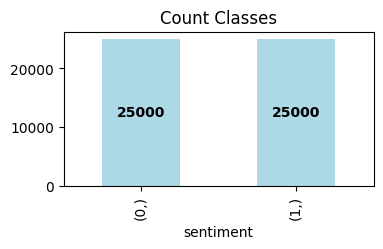

In [7]:
plt.figure(figsize=(4,2))
ax = train[['sentiment']].value_counts().plot(kind='bar',color='lightblue')
ax.bar_label(ax.containers[0],label_type='center',color='black',fontweight='bold');
ax.set_title('Count Classes');

# Feature engineering

In [8]:
# Converter a coluna de datas para datetime
train['datetime'] = pd.to_datetime(train['tweet_date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')
predict['datetime'] = pd.to_datetime(predict['tweet_date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

# Extrair a hora que o tweet foi feito
train['hour'] = train['datetime'].dt.hour
predict['hour'] = predict['datetime'].dt.hour

# Criar colunas dos períodos do dia
# Manhã
train['is_morning'] = train['hour'].between(6, 11).astype(int)
predict['is_morning'] = predict['hour'].between(6, 11).astype(int)

# Tarde
train['is_afternoon'] = train['hour'].between(12, 17).astype(int)
predict['is_afternoon'] = predict['hour'].between(12, 17).astype(int)

# Noite
train['is_night'] = train['hour'].between(18, 23).astype(int)
predict['is_night'] = predict['hour'].between(18, 23).astype(int)

# Madrugada
train['is_dawn'] = train['hour'].between(0, 5).astype(int)
predict['is_dawn'] = predict['hour'].between(0, 5).astype(int)

In [9]:
# Obter o nome do dia da semana
train['weekday_num'] = train['datetime'].dt.weekday
predict['weekday_num'] = predict['datetime'].dt.weekday

# Criar a coluna para indicar se é fim de semana
train['is_weekend'] = train['datetime'].dt.weekday.isin([4, 5, 6]).astype(int)  # Sexta a domingo
predict['is_weekend'] = predict['datetime'].dt.weekday.isin([4, 5, 6]).astype(int)  # Sexta a domingo

In [10]:
# Dias da semana
train['is_monday'] = (train['weekday_num'] == 0).astype(int)
predict['is_monday'] = (predict['weekday_num'] == 0).astype(int)

train['is_tuesday'] = (train['weekday_num'] == 1).astype(int)
predict['is_tuesday'] = (predict['weekday_num'] == 1).astype(int)

train['is_wednesday'] = (train['weekday_num'] == 2).astype(int)
predict['is_wednesday'] = (predict['weekday_num'] == 2).astype(int)

train['is_thursday'] = (train['weekday_num'] == 3).astype(int)
predict['is_thursday'] = (predict['weekday_num'] == 3).astype(int)

train['is_friday'] = (train['weekday_num'] == 4).astype(int)
predict['is_friday'] = (predict['weekday_num'] == 4).astype(int)

train['is_saturday'] = (train['weekday_num'] == 5).astype(int)
predict['is_saturday'] = (predict['weekday_num'] == 5).astype(int)

train['is_sunday'] = (train['weekday_num'] == 6).astype(int)
predict['is_sunday'] = (predict['weekday_num'] == 6).astype(int)

In [11]:
train.head()

id                                         tweet_text  \
0  1049158578504916992                   @Vini_Arisato eu espero que não    
1  1049104603332169728  me diz aí o que vai ser do serviço social com ...   
2  1050780236856651776  inclusive, os nomes que eu uso aqui são de tes...   
3  1047555890654728192  @rangerlol1 Hora da panelinha começar a passar...   
4  1046965203701829632                           Meu neosoro tá acabando    

                       tweet_date  sentiment query_used  \
0  Mon Oct 08 04:44:32 +0000 2018          0         :(   
1  Mon Oct 08 01:10:03 +0000 2018          1         :)   
2  Fri Oct 12 16:08:25 +0000 2018          1         :)   
3  Wed Oct 03 18:36:01 +0000 2018          1         :)   
4  Tue Oct 02 03:28:50 +0000 2018          0         :(   

                   datetime  hour  is_morning  is_afternoon  is_night  \
0 2018-10-08 04:44:32+00:00     4           0             0         0   
1 2018-10-08 01:10:03+00:00     1           0             0         0   
2 2018-10-12 16:08:25+00:00    16           0             1         0   
3 2018-10-03 18:36:01+00:00    18           0             0         1   
4 2018-10-02 03:28:50+00:00     3           0             0         0   

   is_dawn  weekday_num  is_weekend  is_monday  is_tuesday  is_wednesday  \
0        1            0           0          1           0             0   
1        1            0           0          1           0             0   
2        0            4           1          0           0             0   
3        0            2           0          0           0             1   
4        1            1           0          0           1             0   

   is_thursday  is_friday  is_saturday  is_sunday  
0            0          0            0          0  
1            0          0            0          0  
2            0          1            0          0  
3            0          0            0          0  
4            0          0            0          0

<Axes: title={'center': 'Pearson Correlation of Features'}>

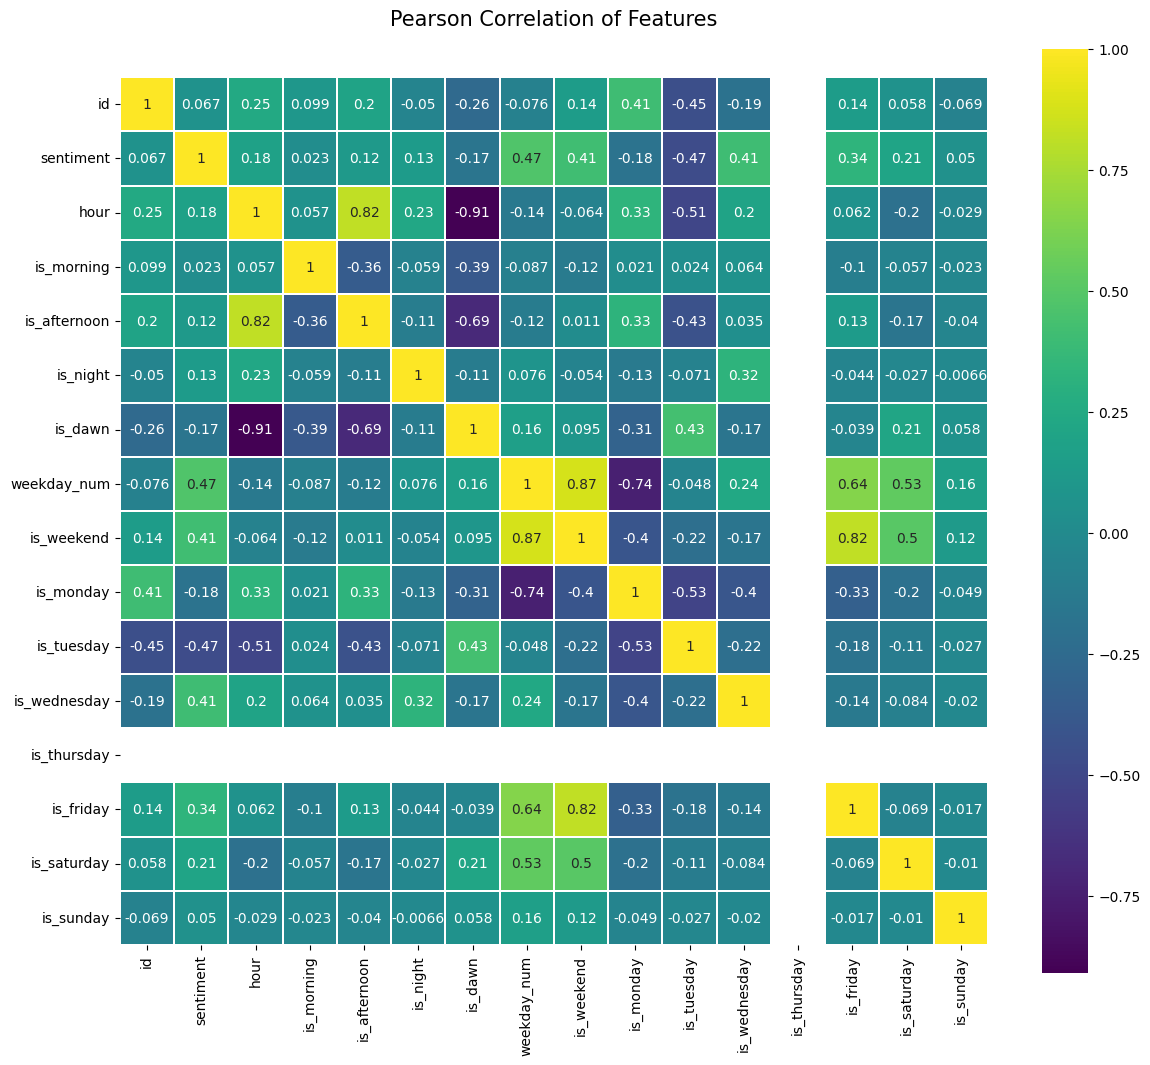

In [12]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.select_dtypes(include=['number']).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
train = train.drop(['hour', 'is_morning', 'is_night','is_dawn', 'weekday_num', 'is_thursday', 'is_sunday'], axis=1)
predict = predict.drop(['hour', 'is_morning', 'is_night','is_dawn', 'weekday_num', 'is_thursday', 'is_sunday'], axis=1)

<Axes: title={'center': 'Pearson Correlation of Features'}>

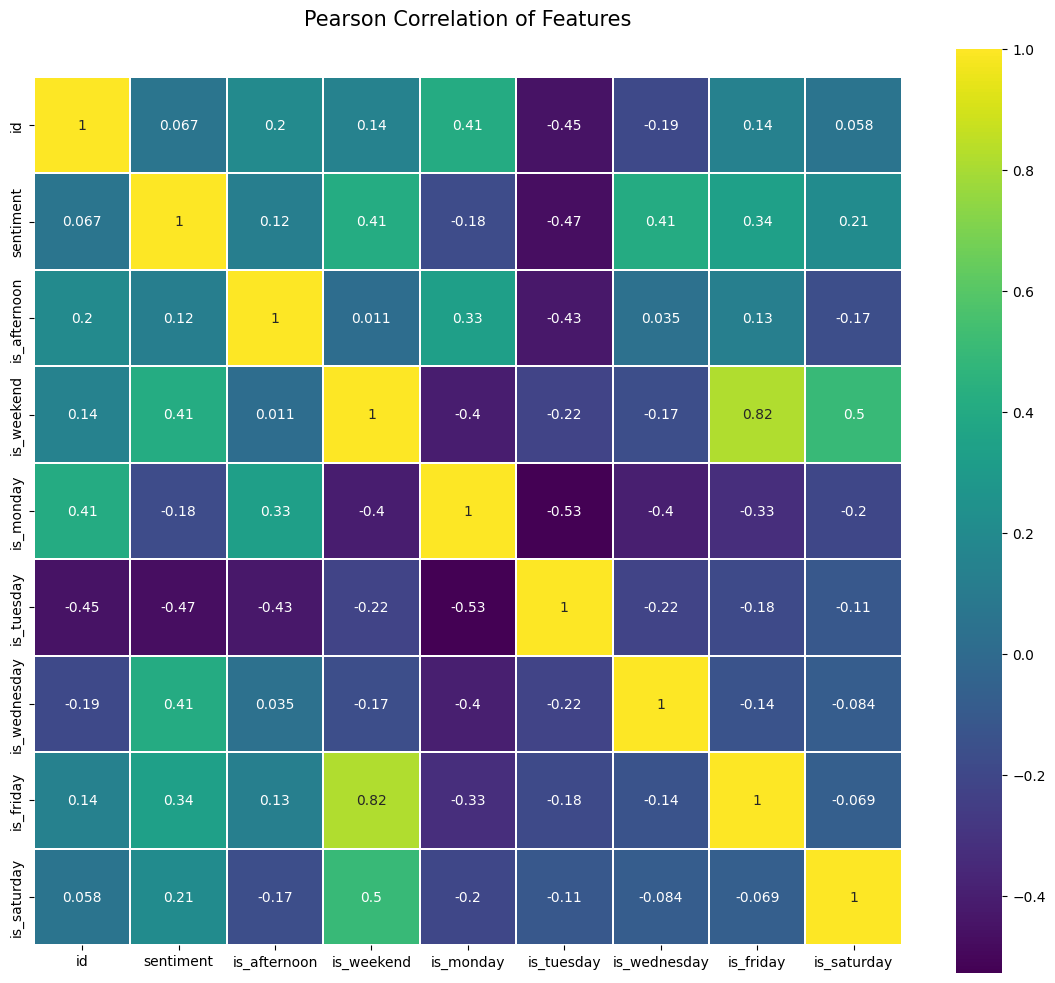

In [14]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.select_dtypes(include=['number']).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Normalizing text

In [15]:
def substitute_emoji(text):
    # Converte emojis no texto para suas descrições em texto (ex.: 😀 -> ":grinning_face:")
    return emoji.demojize(text)

In [16]:
abreviation_dict = {
    "n": "nao",
    "nn": "nao",
    "s": "sim",
    "ss": "sim",
    "vc": "você",
    "pq": "porque",
    "tb": "também",
    "blz": "beleza",
    "vlw": "valeu",
    "flw": "falou",
    "obg": "obrigado",
    "hj": "hoje",
    "fds": "fim de semana",
    "p": "para",
    "cmg": "comigo",
    "ngm": "ninguém",
}

def substitute_abreviations(text, abreviation_dict):
    words = text.split()
    words = [abreviation_dict.get(word, word) for word in words]
    return ' '.join(words)

def clean_text(text):
    # Substitui emojis por descrições em texto
    text = substitute_emoji(text)
    
    # Remove URLs (ex.: "http://example.com", "www.example.com")
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    
    # Remove menções (@usuario), hashtags (#hashtag) e a sigla "RT" (retweets)
    text = re.sub(r'@\w+|#\w+|RT', '', text)
    
    # Remove caracteres que não sejam letras, espaços ou caracteres acentuados
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    text = substitute_abreviations(text, abreviation_dict)

    # Remover caracteres especiais
    text = re.sub(r"[^\w\s]", "", text)
    
    # Converte o texto para minúsculas e remove espaços extras
    text = text.lower().strip()
    
    # Retorna o texto limpo
    return text

In [17]:
# carrega o modelo de processamento de linguagem natural (NLP) do spaCy em português
nlp = spacy.load("pt_core_news_sm")


# palavras geralmente irrelevantes para os mecanismos de analise

custom_stopwords = {
    'pra', 'ta', 'd', 'p', 'pq', 'porque', 'q', 'dps', 
    'c', 'tamo', 'tmj', 'pdc', 'blz', 'vlw', 'flw', 
    'tipo', 'entao', 'aí', 'assim', 'qq', 'tbm', 
    'to', 'tô', 'tava', 'tamos', 'tá', 'vou', 
    'é', 'eh', 'ja', 'já', 'a', 'o', 'os', 'as', 
    'um', 'uns', 'uma', 'umas', 'esse', 'essa', 'isso', 
    'nao', 'não', 'sim', 'ai', 'me', 'se', 'nos', 
    'ele', 'ela', 'eles', 'elas', 'todo', 'tudo', 
    'mais', 'muito', 'mto', 'mt', 'menos', 'lá', 
    'ali', 'cá', 'aqui', 'até', 'de', 'do', 'na', 
    'no', 'em', 'com', 'sem', 'pelo', 'pela', 'sobre',
    'para', 'por', 'dos', 'das', 'que', 'quem', 
    'qual', 'como', 'onde', 'quando', 'porque',
    'ou', 'nem', 'já', 'seu', 'sua', 'meu', 'minha', 
    'nossa', 'nosso', 'essa', 'essa', 'dessa', 'daqui', 'isso', 
    'aquela', 'aquelas', 'aquelou', 'nesse', 'nessa', 'aonde', 
    'outro', 'tão', 'se', 'faz', 'fazendo', 'fez', 'fizeram', 
    'diz', 'disse', 'dizendo', 'dito', 'sim', 'mas', 'porem', 
    'então', 'onde', 'aquela', 'aquelas', 'ambos', 'tambem', 
    'como', 'qual', 'quais', 'estou', 'isso', 'essa', 'este', 
    'estes', 'estas', 'enquanto', 'alguém', 'alguma', 'algumas',
    'ninguém', 'nenhum', 'nenhuma', 'qualquer', 'qualquer', 
    'demais', 'enfim', 'mesmo', 'até', 'já', 'mesma', 'mesmos',
    'pouco', 'todos', 'todas', 'toda', 'porém', 'cara', 'mano',
    'gente', 'querer'
}

stop_words = set(stopwords.words('portuguese')).union(custom_stopwords)

In [18]:
def preprocess_text(text):
    # Processa o texto usando o modelo spaCy carregado
    doc = nlp(text)
    
    # Cria uma lista de radicais para tokens que não sejam stopwords
    tokens = [token.lemma_ for token in doc if token.text not in stop_words]
    
    # Junta os tokens processados em uma única string e a retorna
    return ' '.join(tokens)

In [19]:
def preprocess_pipeline(text):
    # Limpa o texto removendo emojis, URLs, menções, hashtags, caracteres especiais, etc.
    cleaned_text = clean_text(text)
    
    # Realiza o pré-processamento adicional, como lematização e remoção de stopwords
    preprocessed_text = preprocess_text(cleaned_text)
    
    # Retorna o texto final preprocessado
    return preprocessed_text

In [20]:
train['tweet_processed'] = train['tweet_text'].apply(lambda x: preprocess_pipeline(x))
predict['tweet_processed'] = predict['tweet_text'].apply(lambda x: preprocess_pipeline(x))

In [21]:
train

id                                         tweet_text  \
0      1049158578504916992                   @Vini_Arisato eu espero que não    
1      1049104603332169728  me diz aí o que vai ser do serviço social com ...   
2      1050780236856651776  inclusive, os nomes que eu uso aqui são de tes...   
3      1047555890654728192  @rangerlol1 Hora da panelinha começar a passar...   
4      1046965203701829632                           Meu neosoro tá acabando    
...                    ...                                                ...   
49995  1048388839142776832  Qual fic super boa que vc tá lendo? Indica aí ...   
49996  1046928181696126978  @BaptistaIsinha @lovelyoldmagcon @lovoitnb inc...   
49997  1046985016784429058                      a faculdade te muda pra pior    
49998  1050763799509291008  @dbxlro bola de futebol a chamar me de gordo ?...   
49999  1047461514775617536                   Bom dia  https://t.co/VvencX2D9W   

                           tweet_date  sentiment query_used  \
0      Mon Oct 08 04:44:32 +0000 2018          0         :(   
1      Mon Oct 08 01:10:03 +0000 2018          1         :)   
2      Fri Oct 12 16:08:25 +0000 2018          1         :)   
3      Wed Oct 03 18:36:01 +0000 2018          1         :)   
4      Tue Oct 02 03:28:50 +0000 2018          0         :(   
...                               ...        ...        ...   
49995  Sat Oct 06 01:45:52 +0000 2018          1         :)   
49996  Tue Oct 02 01:01:44 +0000 2018          0         :(   
49997  Tue Oct 02 04:47:34 +0000 2018          0         :(   
49998  Fri Oct 12 15:03:06 +0000 2018          1         :)   
49999  Wed Oct 03 12:21:00 +0000 2018          1         :)   

                       datetime  is_afternoon  is_weekend  is_monday  \
0     2018-10-08 04:44:32+00:00             0           0          1   
1     2018-10-08 01:10:03+00:00             0           0          1   
2     2018-10-12 16:08:25+00:00             1           1          0   
3     2018-10-03 18:36:01+00:00             0           0          0   
4     2018-10-02 03:28:50+00:00             0           0          0   
...                         ...           ...         ...        ...   
49995 2018-10-06 01:45:52+00:00             0           1          0   
49996 2018-10-02 01:01:44+00:00             0           0          0   
49997 2018-10-02 04:47:34+00:00             0           0          0   
49998 2018-10-12 15:03:06+00:00             1           1          0   
49999 2018-10-03 12:21:00+00:00             1           0          0   

       is_tuesday  is_wednesday  is_friday  is_saturday  \
0               0             0          0            0   
1               0             0          0            0   
2               0             0          1            0   
3               0             1          0            0   
4               1             0          0            0   
...           ...           ...        ...          ...   
49995           0             0          0            1   
49996           1             0          0            0   
49997           1             0          0            0   
49998           0             0          1            0   
49999           0             1          0            0   

                                         tweet_processed  
0                                                esperar  
1                      ir serviço social bolsonaro poder  
2      inclusive nome usar teste ahdjshsjr ainda test...  
3      hora panelinha começar passar pano falar arrep...  
4                                         neosoro acabar  
...                                                  ...  
49995       fic super bom ler indicar antique shop amore  
49996            inclusive sdds pompom roso cair mochila  
49997                                Faculdade mudar mau  
49998  bola futebol chamar gordo fdp cigarrete saber ...  
49999                                            bom dia  

[50000 rows

# WordCloud

- Representação visual de um conjunto de textos (tweets) em que as palavras mais frequentes e importantes aparecem em maior escala
- Importante também para identificar quais palavras NÃO auxiliam o modelo no processo de aprendizagem (stopwords)

In [22]:
negative_tweets = ' '.join(train[train['sentiment'] == 0]['tweet_processed'])
positive_tweets = ' '.join(train[train['sentiment'] == 1]['tweet_processed'])

stopword = nltk.corpus.stopwords.words('portuguese')
stopword = list(custom_stopwords)+stopword

In [23]:
# WordCloud de tweets negativos
wc_negative = WordCloud(
    stopwords=stopword,
    max_words=2000,
    background_color='white',
    width=1600,
    height=800
)
wc_negative.generate(negative_tweets)
wc_negative.to_file('word_cloud_negative.png')
wc_negative.to_image()

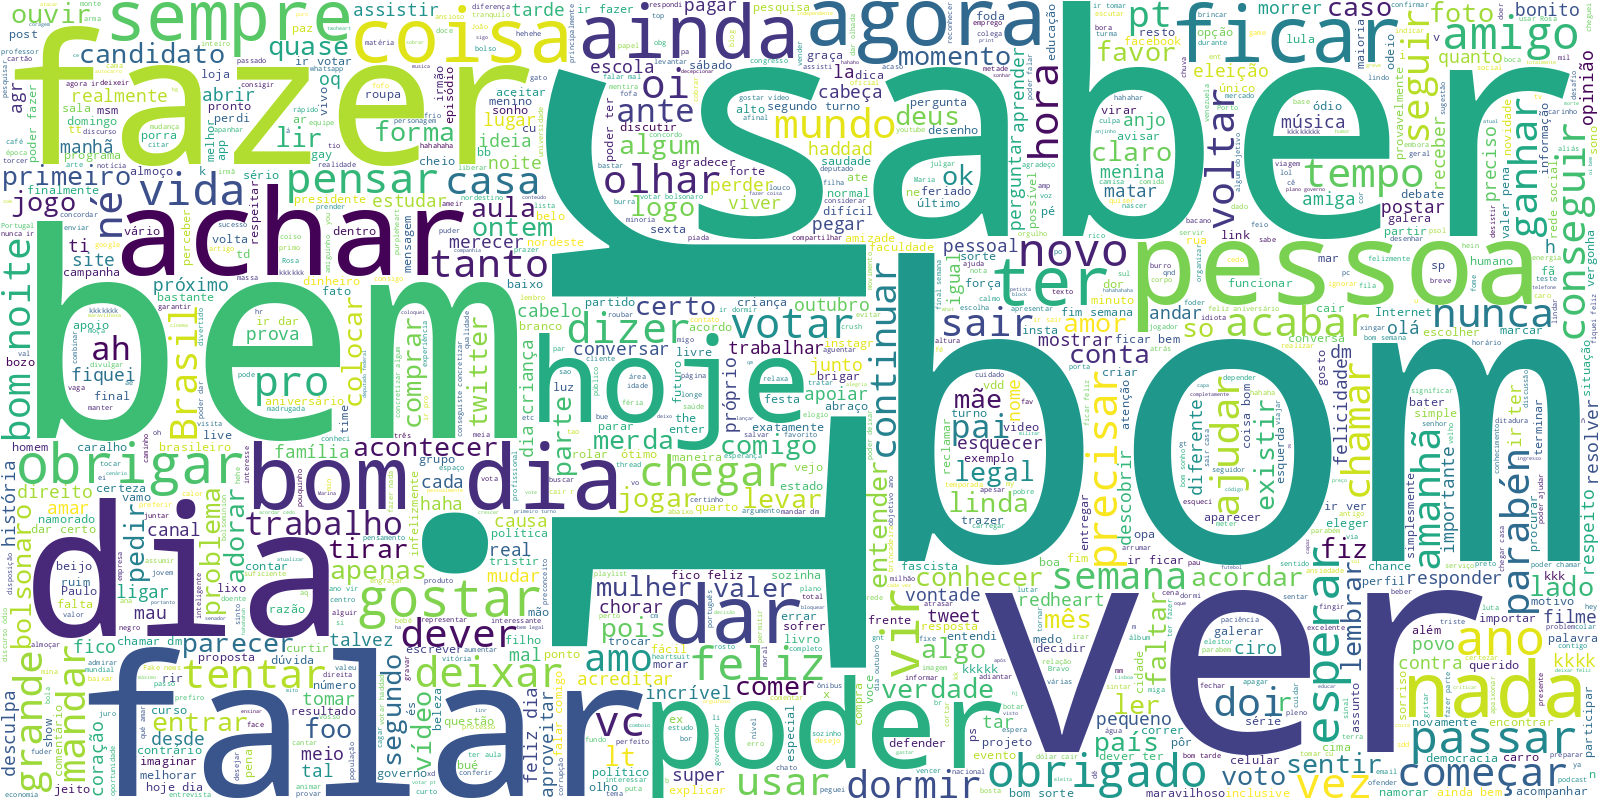

In [24]:
# WordCloud de tweets positivos
wc_positive = WordCloud(
    stopwords=stopword,
    max_words=2000,
    background_color='white',
    width=1600,
    height=800
)
wc_positive.generate(positive_tweets)
wc_positive.to_file('word_cloud_positive.png')
wc_positive.to_image()

In [25]:
cloud_data = ' '.join([line for line in train.tweet_processed])
wc = WordCloud(stopwords=stopword, 
               max_words=2000,
               background_color='white',
               width=1600, 
               height=800)
wc.generate(cloud_data)
wc.to_file('word_cloud.png')
wc.to_image()

# GridSearch

## RandomForestClassifier

In [26]:
models = [{
    'model': RandomForestClassifier,
    'params': {'n_estimators': [5, 10, 100], 'max_depth': [5, 10, 20], 'random_state': [1, 2, 3]}
}]

vectorizers = [{
    'vectorizer': CountVectorizer,
    'params': {'analyzer': ['word'], 'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}, {
    'vectorizer': TfidfVectorizer,
    'params': {'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}]

results = []

for model in models:
    for vectorize in vectorizers:
        params = vectorize['params']
        vectorizer_name = vectorize['vectorizer'].__name__

        vectorizer_param_combinations = list(itertools.product(*params.values()))
        for vec_params in vectorizer_param_combinations:
            vec_params_dict = dict(zip(params.keys(), vec_params))
            vectorizer = vectorize['vectorizer'](**vec_params_dict)

            vectorizer = vectorizer.fit(list(train['tweet_processed']) + list(predict['tweet_processed']))
            X_train_vectorized = vectorizer.transform(train['tweet_processed'])

            # gerar todas as combinações de parâmetros do modelo
            param_combinations = list(itertools.product(*model['params'].values()))

            for combination in param_combinations:
                params_dict = dict(zip(model['params'].keys(), combination))

                # instancia o modelo com a combinação de parâmetros
                model_to_train = model['model'](**params_dict)

                try:
                    scores = cross_val_score(model_to_train, X_train_vectorized, train['sentiment'], cv=5)
                    mean_score = np.mean(scores)

                    results.append({
                        'vectorizer': vectorizer_name,
                        'vectorizer_params': vec_params_dict,
                        'model_params': params_dict,
                        'score': mean_score
                    })

                except ValueError as e:
                    print(f"Erro ao treinar modelo com os parâmetros {params_dict}: {e}")

# encontrar a melhor combinação de parâmetros
best_result = max(results, key=lambda x: x['score'])

print("Melhor combinação de parâmetros:")
print(f"Vectorizer: {best_result['vectorizer']}")
print(f"Parâmetros do Vectorizer: {best_result['vectorizer_params']}")
print(f"Parâmetros do Modelo: {best_result['model_params']}")
print(f"Score médio: {best_result['score']}")


Melhor combinação de parâmetros:
Vectorizer: TfidfVectorizer
Parâmetros do Vectorizer: {'ngram_range': (1, 1)}
Parâmetros do Modelo: {'n_estimators': 100, 'max_depth': 20, 'random_state': 1}
Score médio: 0.70788


## LinearSVC

In [27]:
models = [{
    'model': LinearSVC,
    'params': {'penalty': ['l2'], 'C': [0.1, 1], 'loss': ['hinge', 'squared_hinge'], 
               'max_iter': [100, 500, 1000], 'dual': [True, False]}
}]

vectorizers = [{
    'vectorizer': CountVectorizer,
    'params': {'analyzer': ['word'], 'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}, {
    'vectorizer': TfidfVectorizer,
    'params': {'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}]

results = []

for model in models:
    for vectorize in vectorizers:
        params = vectorize['params']
        vectorizer_name = vectorize['vectorizer'].__name__

        vectorizer_param_combinations = list(itertools.product(*params.values()))
        for vec_params in vectorizer_param_combinations:
            vec_params_dict = dict(zip(params.keys(), vec_params))
            vectorizer = vectorize['vectorizer'](**vec_params_dict)

            vectorizer = vectorizer.fit(list(train['tweet_processed']) + list(predict['tweet_processed']))
            X_train_vectorized = vectorizer.transform(train['tweet_processed'])

            # Gerar todas as combinações de parâmetros do modelo
            param_combinations = list(itertools.product(*model['params'].values()))

            for combination in param_combinations:
                params_dict = dict(zip(model['params'].keys(), combination))

                # Ajustar 'dual' automaticamente com base nos parâmetros
                if params_dict['penalty'] == 'l2' and params_dict['loss'] == 'hinge':
                    params_dict['dual'] = True

                # Instancia o modelo com a combinação de parâmetros
                model_to_train = model['model'](**params_dict)

                # Avaliação do modelo
                try:
                    scores = cross_val_score(model_to_train, X_train_vectorized, train['sentiment'], cv=5)
                    mean_score = np.mean(scores)

                    # Armazenar o resultado, incluindo os parâmetros do vetorizer e do modelo
                    results.append({
                        'vectorizer': vectorizer_name,
                        'vectorizer_params': vec_params_dict,
                        'model_params': params_dict,
                        'score': mean_score
                    })

                except ValueError as e:
                    print(f"Erro ao treinar modelo com os parâmetros {params_dict}: {e}")

# encontrar a melhor combinação de parâmetros
best_result = max(results, key=lambda x: x['score'])

print("Melhor combinação de parâmetros:")
print(f"Vectorizer: {best_result['vectorizer']}")
print(f"Parâmetros do Vectorizer: {best_result['vectorizer_params']}")
print(f"Parâmetros do Modelo: {best_result['model_params']}")
print(f"Score médio: {best_result['score']}")


Melhor combinação de parâmetros:
Vectorizer: TfidfVectorizer
Parâmetros do Vectorizer: {'ngram_range': (1, 3)}
Parâmetros do Modelo: {'penalty': 'l2', 'C': 1, 'loss': 'hinge', 'max_iter': 100, 'dual': True}
Score médio: 0.7473799999999999


## LogisticRegression

In [28]:
models = [{
    'model': LogisticRegression,
    'params': {'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'saga'], 
               'max_iter': [100, 500, 1000]}
}]

vectorizers = [{
    'vectorizer': CountVectorizer,
    'params': {'analyzer': ['word'], 'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}, {
    'vectorizer': TfidfVectorizer,
    'params': {'ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]}
}]

# Lista para armazenar resultados
results = []

# Iteração sobre modelos e vetorizadores
for model in models:
    for vectorize in vectorizers:
        params = vectorize['params']
        vectorizer_name = vectorize['vectorizer'].__name__

        # Iterar sobre as combinações de parâmetros do vetorizador
        vectorizer_param_combinations = list(itertools.product(*params.values()))
        for vec_params in vectorizer_param_combinations:
            vec_params_dict = dict(zip(params.keys(), vec_params))
            vectorizer = vectorize['vectorizer'](**vec_params_dict)

            vectorizer = vectorizer.fit(list(train['tweet_processed']) + list(predict['tweet_processed']))
            X_train_vectorized = vectorizer.transform(train['tweet_processed'])

            # gerar todas as combinações de parâmetros do modelo
            param_combinations = list(itertools.product(*model['params'].values()))

            # iterar sobre as combinações de parâmetros do modelo
            for combination in param_combinations:
                params_dict = dict(zip(model['params'].keys(), combination))

                # Instancia o modelo com a combinação de parâmetros
                model_to_train = model['model'](**params_dict)

                try:
                    scores = cross_val_score(model_to_train, X_train_vectorized, train['sentiment'], cv=5)
                    mean_score = np.mean(scores)

                    results.append({
                        'vectorizer': vectorizer_name,
                        'vectorizer_params': vec_params_dict,
                        'model_params': params_dict,
                        'score': mean_score
                    })

                except ValueError as e:
                    print(f"Erro ao treinar modelo com os parâmetros {params_dict}: {e}")

# encontrar a melhor combinação de parâmetros
best_result = max(results, key=lambda x: x['score'])

print("Melhor combinação de parâmetros:")
print(f"Vectorizer: {best_result['vectorizer']}")
print(f"Parâmetros do Vectorizer: {best_result['vectorizer_params']}")
print(f"Parâmetros do Modelo: {best_result['model_params']}")
print(f"Score médio: {best_result['score']}")


Melhor combinação de parâmetros:
Vectorizer: TfidfVectorizer
Parâmetros do Vectorizer: {'ngram_range': (1, 2)}
Parâmetros do Modelo: {'penalty': 'l2', 'C': 1, 'solver': 'lbfgs', 'max_iter': 100}
Score médio: 0.74436


# Splitting variables

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train, train['sentiment'], test_size=0.2, random_state=1)

# Model used

In [30]:
vectorizer = CountVectorizer(analyzer='word',ngram_range=(4, 4))
#vectorizer = vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer = vectorizer.fit(list(X_train['tweet_processed'])+list(X_test['tweet_processed'])+list(predict['tweet_processed']))

X_train_vectorized = vectorizer.transform(X_train['tweet_processed'])
X_test_vectorized = vectorizer.transform(X_test['tweet_processed'])
predict_vectorized = vectorizer.transform(predict['tweet_processed'])

In [31]:
model_svc = LinearSVC(C=1.0, max_iter=1000, loss='hinge', dual=True,random_state=1)
#model_svc = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=1)
model_svc.fit(X_train_vectorized, y_train)
print(model_svc.score(X_train_vectorized, y_train))

X_train['model_predicts'] = model_svc.predict(X_train_vectorized)
X_test['model_predicts'] = model_svc.predict(X_test_vectorized)
predict['model_predicts'] = model_svc.predict(predict_vectorized)

0.82305


# RandomForest (selecting variables)

In [32]:
features = ['is_tuesday', 'is_wednesday', 'model_predicts']
#treinar o random forest
id_train = X_train['id']
X_train = X_train[features]

id_test = X_test['id']
X_test = X_test[features]

id_predict = predict['id']
data_to_predict = predict[features]

In [33]:
# Definir a grade de parâmetros
param_grid_rf = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                           param_grid=param_grid_rf,
                           cv=5,
                           scoring='accuracy', 
                           n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search_rf.best_params_)
print("Melhor acurácia:", grid_search_rf.best_score_)

Melhores parâmetros: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Melhor acurácia: 0.874475


In [34]:
# creating the best model
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

# training the model with the training data
model_rf.fit(X_train, y_train)
model_rf.score(X_train, y_train)

0.874475

# DecisionTree

- O modelo tenta maximizar a pureza dos nós (reduzir o índice Gini) a cada divisão.
- Ele decide qual variável (feature) usar como divisão e onde fazer o corte (threshold) para atingir esse objetivo.
- Samples: número de amostras (linhas do dataset) presentes no nó.
Exemplo: samples = 25182 no nó raiz indica que a árvore está analisando todas as 25.182 amostras.
- No final, os nós folhas contêm uma decisão final baseada na classe dominante no value.

In [35]:
"""dot_data = export_graphviz(
    single_tree,
    out_file=None,
    feature_names=features,
    class_names=['Negative tweet', 'Positive tweet'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("random_forest_tree")  # Salva como arquivo .pdf ou .png
graph.view()
"""

'dot_data = export_graphviz(\n    single_tree,\n    out_file=None,\n    feature_names=features,\n    class_names=[\'Negative tweet\', \'Positive tweet\'],\n    filled=True,\n    rounded=True,\n    special_characters=True\n)\ngraph = graphviz.Source(dot_data)\ngraph.render("random_forest_tree")  # Salva como arquivo .pdf ou .png\ngraph.view()\n'

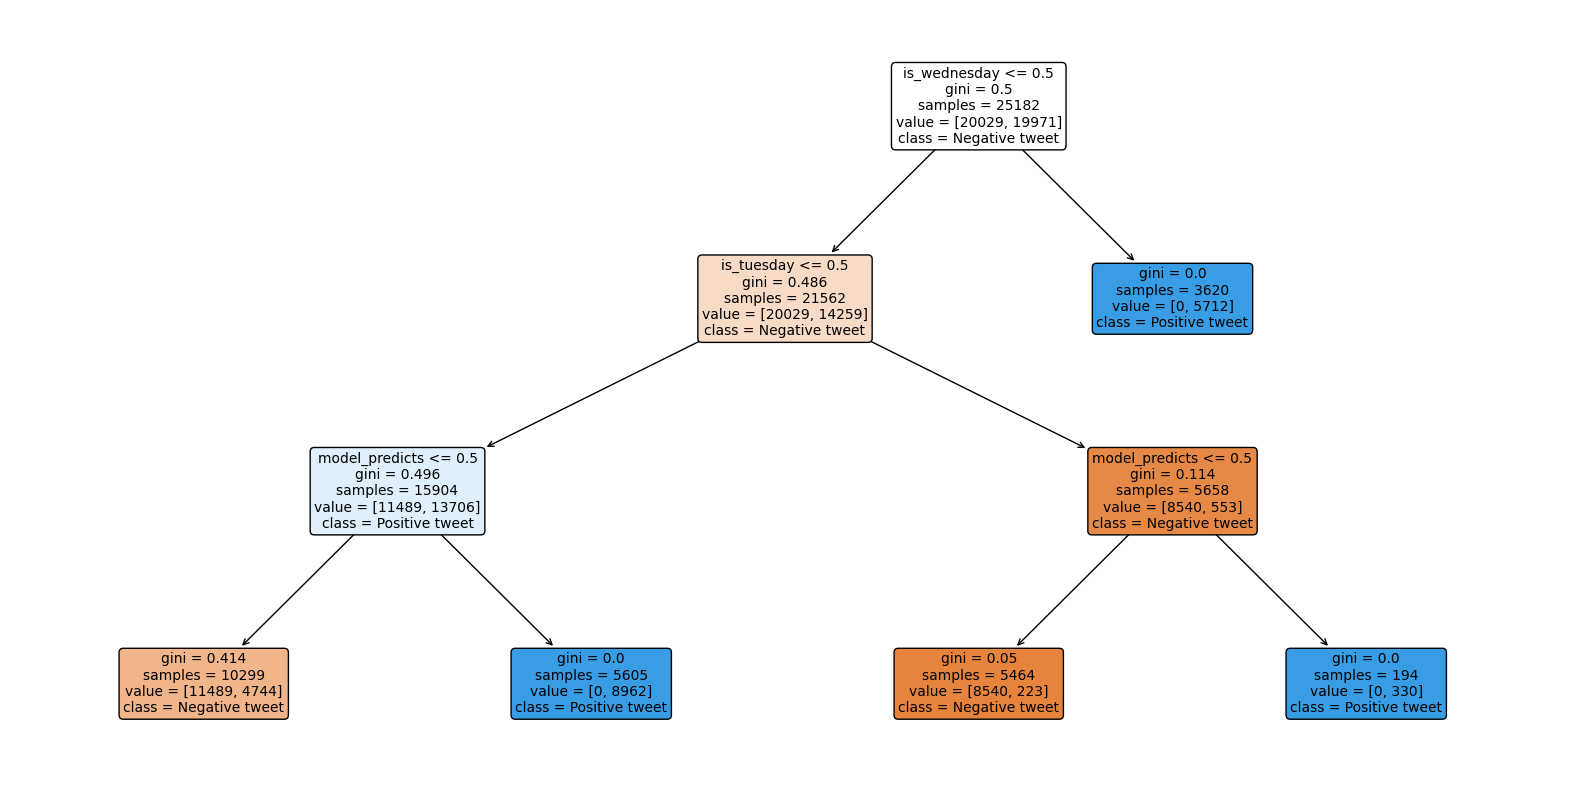

In [36]:
# Selecionar uma árvore do Random Forest
tree_index = 0  # Índice da árvore que você quer visualizar
single_tree = model_rf.estimators_[tree_index]

# Visualizar a árvore usando plot_tree (simples e direto)
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=features,
    class_names=['Negative tweet', 'Positive tweet'],  # Substitua pelos nomes reais das classes, se necessário
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

Conclusão Geral:

- A maioria dos tweets feitos na quarta-feira são, invariavelmente, positivos.
- Grande parte dos tweets da terça-feira apresentam um  viés negativo, mas as previsões textuais ajudam a refinar o sentimento.
- O modelo demonstra que o contexto temporal (dia da semana) influencia significativamente no sentimento expresso, além das características textuais.

In [37]:
val_predictions = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, val_predictions)
print(f"Accuracy no conjunto de validação: {accuracy}")

Accuracy no conjunto de validação: 0.6417


# Submission

In [38]:
data_to_predict

is_tuesday  is_wednesday  model_predicts
0              0             1               0
1              0             0               0
2              0             0               0
3              0             1               0
4              0             1               0
...          ...           ...             ...
4995           0             0               0
4996           0             1               0
4997           0             0               0
4998           0             0               0
4999           0             1               0

[5000 rows x 3 columns]

In [39]:
previsoes = model_rf.predict(data_to_predict)

np.set_printoptions(threshold=np.inf)

# Contar valores 0 e 1
counts = np.bincount(previsoes)
qtd_zeros = counts[0]  # Quantidade de 0
qtd_ones = counts[1]   # Quantidade de 1

print(f"Quantidade de tweets NEGATIVOS: {qtd_zeros}")
print(f"Quantidade de tweets POSITIVOS: {qtd_ones}")

Quantidade de tweets NEGATIVOS: 2500
Quantidade de tweets POSITIVOS: 2500


In [40]:
data_to_predict = data_to_predict.copy()
data_to_predict['id'] = predict['id']

# Reorganiza as colunas do DataFrame
data_to_predict = data_to_predict[['id'] + [col for col in data_to_predict.columns if col != 'id']]

data_to_predict

id  is_tuesday  is_wednesday  model_predicts
0     1029570266916159488           0             1               0
1     1030496040649142272           0             0               0
2     1030496928755314688           0             0               0
3     1029559076815097856           0             1               0
4     1029551213866573830           0             1               0
...                   ...         ...           ...             ...
4995  1030520190151340033           0             0               0
4996  1029546296087130112           0             1               0
4997  1030502469615403008           0             0               0
4998  1030510914045390849           0             0               0
4999  1029554935845797888           0             1               0

[5000 rows x 4 columns]

In [41]:
# creating the submission file
output = pd.DataFrame({'id': data_to_predict.id, 'sentiment': previsoes})
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
